In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# For example, here's several helpful packages to load



import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



# Input data files are available in the read-only "../input/" directory

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# import os

# for dirname, _, filenames in os.walk('/kaggle/input'):

#     for filename in filenames:

#         print(os.path.join(dirname, filename))



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

In [3]:
import os

import torch

import pandas as pd

import numpy as np

from torch.utils.data import Dataset, random_split, DataLoader

from PIL import Image

import torchvision.models as models

from tqdm.notebook import tqdm

import torchvision.transforms as T

import torch.nn.functional as F

import torch.nn as nn

from torchvision.utils import make_grid

from sklearn.preprocessing import LabelEncoder



import os

import re

import requests



import matplotlib.pyplot as plt

%matplotlib inline



import warnings

warnings.filterwarnings('ignore')

In [ ]:
train_dir = '../Dataset/train_images'

test_dir = '../Dataset/test_images'

train_csv = '../Dataset/train.csv'

test_csv = '../Dataset/test.csv'

sample_submission = '../Dataset/sample_submission.csv'

cat_attr = '../Dataset/category_attributes.parquet'

In [5]:
model_category = 'Women Tshirts'

In [6]:
train_df = pd.read_csv(train_csv)

train_df

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10
0,0,Men Tshirts,5,default,round,printed,default,short sleeves,NaN,NaN,NaN,NaN,NaN
1,1,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
2,2,Men Tshirts,5,default,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
3,3,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
4,4,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70208,70374,Women Tops & Tunics,10,multicolor,fitted,regular,square neck,casual,printed,default,short sleeves,regular sleeves,ruffles
70209,70375,Women Tops & Tunics,10,yellow,regular,crop,round neck,casual,default,default,short sleeves,regular sleeves,knitted
70210,70376,Women Tops & Tunics,10,maroon,fitted,crop,round neck,casual,solid,solid,short sleeves,regular sleeves,knitted
70211,70377,Women Tops & Tunics,10,NaN,NaN,NaN,high,NaN,NaN,NaN,short sleeves,NaN,NaN


In [ ]:
train_df_cat = train_df[train_df['Category'] == model_category]

n = 10 - (train_df_cat['len'].values[0])

if (n != 0):

    train_df_cat.drop(columns=train_df_cat.columns[-n:], axis=1, inplace=True)

# train_df_cat.drop(["attr_6","attr_7","attr_8","attr_9","attr_10"], axis =1, inplace = True)

train_df_cat

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8
32435,32601,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN
32436,32602,Women Tshirts,8,yellow,loose,long,default,default,long sleeves,regular sleeves,NaN
32437,32603,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN
32438,32604,Women Tshirts,8,multicolor,loose,long,default,default,long sleeves,regular sleeves,NaN
32439,32605,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN
...,...,...,...,...,...,...,...,...,...,...,...
51204,51370,Women Tshirts,8,white,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51205,51371,Women Tshirts,8,white,regular,crop,printed,typography,short sleeves,regular sleeves,NaN
51206,51372,Women Tshirts,8,NaN,NaN,NaN,printed,typography,short sleeves,regular sleeves,NaN
51207,51373,Women Tshirts,8,white,regular,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
cat_attr_df = pd.read_parquet(cat_attr)

pd.set_option('display.max_colwidth', None)

cat_attr_df

,Category,No_of_attribute,Attribute_list
0,Men Tshirts,5,"[color, neck, pattern, print_or_pattern_type, sleeve_length]"
1,Sarees,10,"[blouse_pattern, border, border_width, color, occasion, ornamentation, pallu_details, pattern, print_or_pattern_type, transparency]"
2,Kurtis,9,"[color, fit_shape, length, occasion, ornamentation, pattern, print_or_pattern_type, sleeve_length, sleeve_styling]"
3,Women Tshirts,8,"[color, fit_shape, length, pattern, print_or_pattern_type, sleeve_length, sleeve_styling, surface_styling]"
4,Women Tops & Tunics,10,"[color, fit_shape, length, neck_collar, ocassion, pattern, print_or_pattern_type, sleeve_length, sleeve_styling, surface_styling]"


In [ ]:
# Step 1: Extract the attribute list for "Men Tshirts" from cat_attr_df

men_tshirts_attributes = cat_attr_df.loc[cat_attr_df['Category'] == model_category, 'Attribute_list'].values[0]



# Step 2: Create a mapping for the columns

# Assuming attr_1 corresponds to the first item in Attribute_list, attr_2 to the second, etc.

attr_columns = train_df_cat.filter(like='attr_').columns.to_list() # Adjust if more attributes exist

print(attr_columns)

rename_dict = {f'attr_{i+1}': men_tshirts_attributes[i] for i in range(len(attr_columns))}



# Step 3: Rename the columns in Men_Tshirts_df

# train_df_cat.rename(columns=rename_dict, inplace=True)



# Now you can print or check the updated DataFrame

train_df_cat

['attr_1', 'attr_2', 'attr_3', 'attr_4', 'attr_5', 'attr_6', 'attr_7', 'attr_8']


,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8
32435,32601,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN
32436,32602,Women Tshirts,8,yellow,loose,long,default,default,long sleeves,regular sleeves,NaN
32437,32603,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN
32438,32604,Women Tshirts,8,multicolor,loose,long,default,default,long sleeves,regular sleeves,NaN
32439,32605,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN
...,...,...,...,...,...,...,...,...,...,...,...
51204,51370,Women Tshirts,8,white,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51205,51371,Women Tshirts,8,white,regular,crop,printed,typography,short sleeves,regular sleeves,NaN
51206,51372,Women Tshirts,8,NaN,NaN,NaN,printed,typography,short sleeves,regular sleeves,NaN
51207,51373,Women Tshirts,8,white,regular,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def format_image_path(row):

    return f"../Dataset/train_images/{str(row['id']).zfill(6)}.jpg"



# Add the new column 'image_path' using the formatted id

train_df_cat['image_path'] = train_df_cat.apply(format_image_path, axis=1)

train_df_cat

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,image_path
32435,32601,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/032601.jpg
32436,32602,Women Tshirts,8,yellow,loose,long,default,default,long sleeves,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/032602.jpg
32437,32603,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/032603.jpg
32438,32604,Women Tshirts,8,multicolor,loose,long,default,default,long sleeves,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/032604.jpg
32439,32605,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/032605.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
51204,51370,Women Tshirts,8,white,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/kaggle/input/visual-taxonomy/train_images/051370.jpg
51205,51371,Women Tshirts,8,white,regular,crop,printed,typography,short sleeves,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/051371.jpg
51206,51372,Women Tshirts,8,NaN,NaN,NaN,printed,typography,short sleeves,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/051372.jpg
51207,51373,Women Tshirts,8,white,regular,NaN,NaN,NaN,NaN,NaN,NaN,/kaggle/input/visual-taxonomy/train_images/051373.jpg


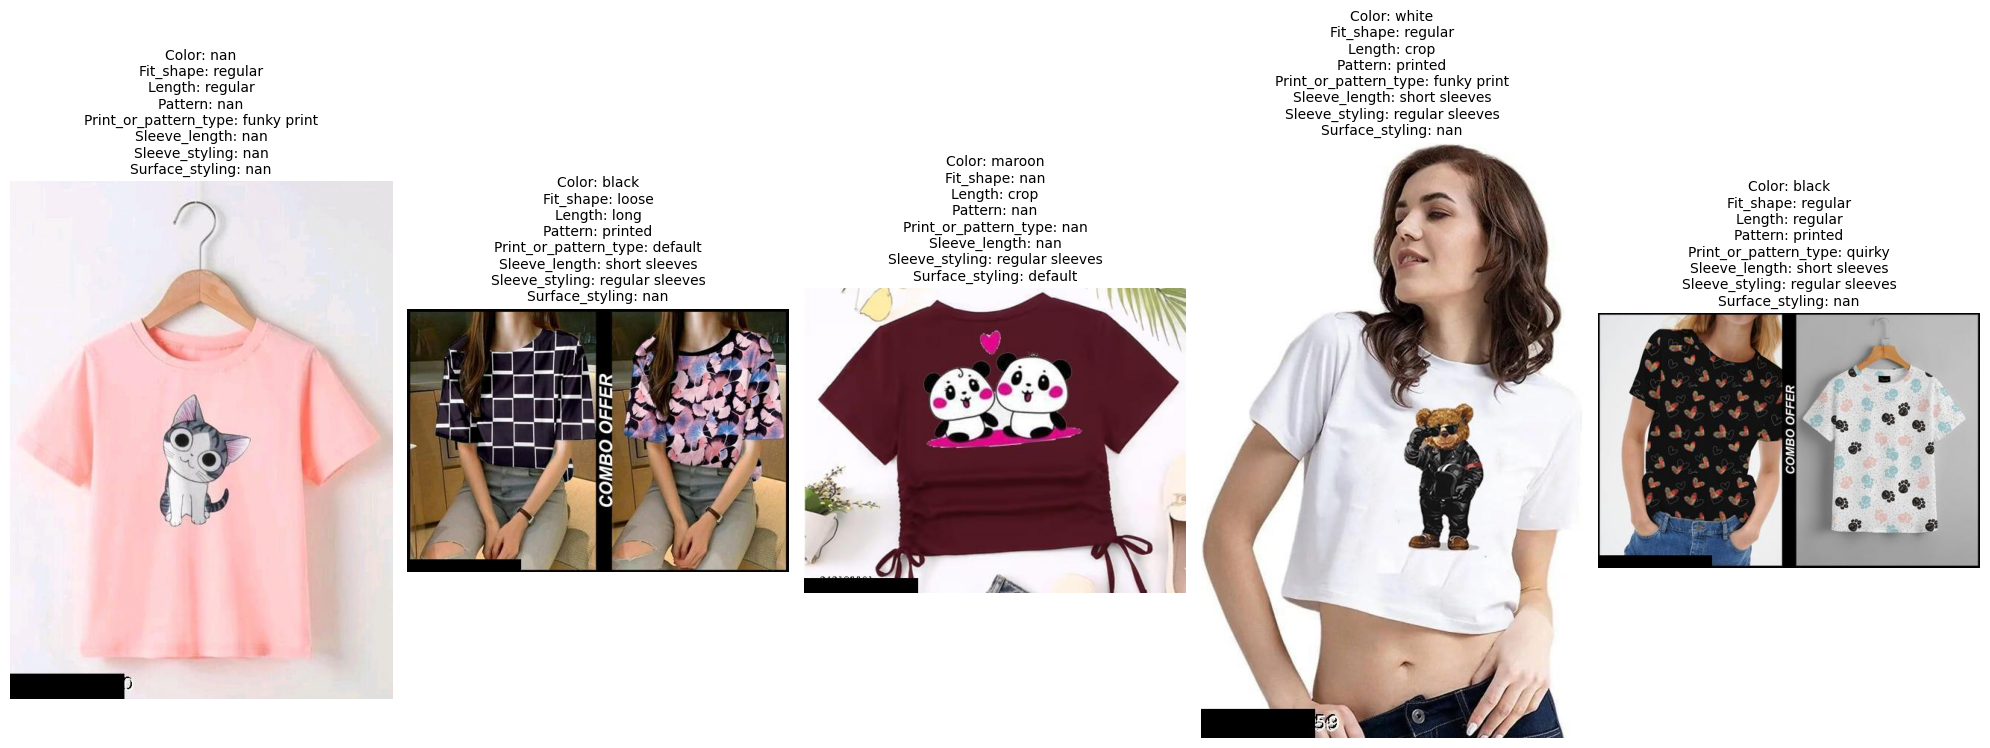

In [ ]:
import matplotlib.pyplot as plt

import pandas as pd

import matplotlib.image as mpimg



# Sample 5 random images from the DataFrame

sample_df = train_df_cat.sample(5)



# Create subplots to display the images with their labels

fig, axes = plt.subplots(1, 5, figsize=(20, 10))  # 5 images, side by side



# Loop through each image and label

for i, (idx, row) in enumerate(sample_df.iterrows()):

    # Read the image

    img = mpimg.imread(row['image_path'])

    

    # Display the image in the subplot

    axes[i].imshow(img)

    axes[i].axis('off')  # Turn off the axis for a cleaner look

    

    # Set the title with the labels

    label = ""

    for attr, renamed_key in rename_dict.items():

        label += f"{renamed_key.capitalize()}: {row[attr]}\n"



    # Remove the last newline character

    label = label.strip()

    axes[i].set_title(label, fontsize=10)



# Show the plot

plt.tight_layout()

plt.show()

In [ ]:
# Get value counts for each specified column

columns_of_interest = attr_columns



for column in columns_of_interest:

    print(f"Value counts for {column}:\n")

    print(train_df_cat[column].value_counts(dropna=False))  # Including NaN values

    print("\n" + "-"*50 + "\n")

Value counts for attr_1:

attr_1
white         4650
default       4297
black         2999
yellow        1838
NaN           1489
multicolor    1392
pink          1380
maroon         729
Name: count, dtype: int64

--------------------------------------------------

Value counts for attr_2:

attr_2
regular    12376
NaN         3973
loose       1483
boxy         942
Name: count, dtype: int64

--------------------------------------------------

Value counts for attr_3:

attr_3
regular    8187
crop       6711
NaN        2194
long       1682
Name: count, dtype: int64

--------------------------------------------------

Value counts for attr_4:

attr_4
printed    14285
NaN         2613
default     1040
solid        836
Name: count, dtype: int64

--------------------------------------------------

Value counts for attr_5:

attr_5
typography     5483
funky print    4172
default        2254
quirky         2179
graphic        2038
NaN            1740
solid           908
Name: count, dtype: int64



In [13]:
# Set up device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
from torchvision import models, transforms

preprocess = transforms.Compose([

    transforms.Resize((256, 256)),

    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply Color Jitter

    transforms.RandomHorizontalFlip(),  # Apply Horizontal Flip with 50% probability

    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# for attribute in [f'attr_{j+1}' for j in range(10)]:

#     le = LabelEncoder()

#     train_df_cat[attribute] = le.fit_transform(train_df_cat[attribute].astype(str))  # Convert NaNs to 'nan' string for encoding

# #     label_encoders[attribute] = le

In [ ]:
train_df_cat

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,image_path
32435,32601,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/032601.jpg
32436,32602,Women Tshirts,8,yellow,loose,long,default,default,long sleeves,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/032602.jpg
32437,32603,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/032603.jpg
32438,32604,Women Tshirts,8,multicolor,loose,long,default,default,long sleeves,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/032604.jpg
32439,32605,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/032605.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
51204,51370,Women Tshirts,8,white,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/kaggle/input/visual-taxonomy/train_images/051370.jpg
51205,51371,Women Tshirts,8,white,regular,crop,printed,typography,short sleeves,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/051371.jpg
51206,51372,Women Tshirts,8,NaN,NaN,NaN,printed,typography,short sleeves,regular sleeves,NaN,/kaggle/input/visual-taxonomy/train_images/051372.jpg
51207,51373,Women Tshirts,8,white,regular,NaN,NaN,NaN,NaN,NaN,NaN,/kaggle/input/visual-taxonomy/train_images/051373.jpg


In [17]:
class ShirtDataset(Dataset):

    def __init__(self, dataframe, attribute, transform=None):

        self.dataframe = dataframe

        self.attribute = attribute

        self.transform = transform



    def __len__(self):

        return len(self.dataframe)



    def __getitem__(self, idx):

        row = self.dataframe.iloc[idx]

        img = Image.open(row['image_path']).convert("RGB")

        if self.transform:

            img = self.transform(img)

        

        # Get attribute label (NaN values handled by replacing with -1)

        label = row[self.attribute] if not pd.isna(row[self.attribute]) else -1

        return img, label



# Function to train DenseNet for a specific attribute

def train_densenet(df, attribute):

    # Filter rows with non-NaN values for training

    train_df = df[df[attribute].notna()].copy()  # Use only rows with valid labels

#     for attribute in [f'attr_{j+1}' for j in range(10)]:

    le = LabelEncoder()

    train_df[attribute] = le.fit_transform(train_df[attribute].astype(str))  # Convert NaNs to 'nan' string for encoding

#     label_encoders[attribute] = le

    



    # Define dataset and dataloader

    train_dataset = ShirtDataset(train_df, attribute, transform=preprocess)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



    # Load a pre-trained DenseNet model and adjust final layer

    densenet = models.efficientnet_b5(pretrained=True)

    num_features = 2048

    densenet.classifier = nn.Linear(num_features, len(train_df[attribute].unique()))

    densenet = densenet.to(device)



    # Define loss and optimizer

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(densenet.parameters(), lr=0.0001)



    # Training loop

    densenet.train()

    for epoch in range(4):  # Use more epochs as needed

        for images, labels in tqdm(train_loader, desc=f"Training {attribute}"):

            images = images.to(device)

            labels = labels.to(device).long()

            

            # Forward pass

            outputs = densenet(images)

            loss = criterion(outputs, labels)

            

            # Backward and optimize

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()



    # Set model to evaluation mode

    densenet.eval()

    return densenet,le



# Function to impute missing values using the trained DenseNet

def impute_attribute(df, attribute, model,le):

    # Dataset and loader for missing values

    nan_df = df[df[attribute].isna()].copy()  # Select rows with NaN in the attribute

    nan_dataset = ShirtDataset(nan_df, attribute, transform=preprocess)

    nan_loader = DataLoader(nan_dataset, batch_size=32, shuffle=False)



    predictions = []

    with torch.no_grad():

        for images, _ in tqdm(nan_loader, desc=f"Predicting {attribute}"):

            images = images.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())

            predictions_ = le.inverse_transform(np.array(predictions))



    # Fill NaNs with predictions

    df.loc[df[attribute].isna(), attribute] = predictions_

    print(df.info())

    return df

In [ ]:
from tqdm import tqdm



for j in tqdm(range(8)):

    model,le = train_densenet(train_df_cat,f'attr_{j+1}')

    train_df_cat = impute_attribute(train_df_cat,f'attr_{j+1}',model,le)

  0%|          | 0/8 [00:00<?, ?it/s]Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth

  0%|          | 0.00/117M [00:00<?, ?B/s]
  3%|▎         | 3.50M/117M [00:00<00:03, 35.1MB/s]
  8%|▊         | 9.25M/117M [00:00<00:02, 49.7MB/s]
 27%|██▋       | 31.4M/117M [00:00<00:00, 132MB/s] 
 46%|████▌     | 53.5M/117M [00:00<00:00, 171MB/s]
 65%|██████▍   | 75.6M/117M [00:00<00:00, 193MB/s]
100%|██████████| 117M/117M [00:00<00:00, 176MB/s] 

Training attr_1: 100%|██████████| 541/541 [07:33<00:00,  1.19it/s]

Training attr_1: 100%|██████████| 541/541 [06:25<00:00,  1.40it/s]

Training attr_1: 100%|██████████| 541/541 [06:25<00:00,  1.40it/s]

Training attr_1: 100%|██████████| 541/541 [06:26<00:00,  1.40it/s]

 12%|█▎        | 1/8 [27:24<3:11:54, 1644.92s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 18774 entries, 32435 to 51208
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          18774 non-null  int64 
 1   Category    18774 non-null  object
 2   len         18774 non-null  int64 
 3   attr_1      18774 non-null  object
 4   attr_2      14801 non-null  object
 5   attr_3      16580 non-null  object
 6   attr_4      16161 non-null  object
 7   attr_5      17034 non-null  object
 8   attr_6      16041 non-null  object
 9   attr_7      15460 non-null  object
 10  attr_8      510 non-null    object
 11  image_path  18774 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.9+ MB
None



Training attr_2: 100%|██████████| 463/463 [05:30<00:00,  1.40it/s]

Training attr_2: 100%|██████████| 463/463 [05:31<00:00,  1.40it/s]

Training attr_2: 100%|██████████| 463/463 [05:30<00:00,  1.40it/s]

Training attr_2: 100%|██████████| 463/463 [05:31<00:00,  1.40it/s]

 25%|██▌       | 2/8 [50:44<2:30:02, 1500.40s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 18774 entries, 32435 to 51208
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          18774 non-null  int64 
 1   Category    18774 non-null  object
 2   len         18774 non-null  int64 
 3   attr_1      18774 non-null  object
 4   attr_2      18774 non-null  object
 5   attr_3      16580 non-null  object
 6   attr_4      16161 non-null  object
 7   attr_5      17034 non-null  object
 8   attr_6      16041 non-null  object
 9   attr_7      15460 non-null  object
 10  attr_8      510 non-null    object
 11  image_path  18774 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.9+ MB
None



Training attr_3: 100%|██████████| 519/519 [06:11<00:00,  1.40it/s]

Training attr_3: 100%|██████████| 519/519 [06:10<00:00,  1.40it/s]

Training attr_3: 100%|██████████| 519/519 [06:11<00:00,  1.40it/s]

Training attr_3: 100%|██████████| 519/519 [06:11<00:00,  1.40it/s]

 38%|███▊      | 3/8 [1:16:10<2:06:01, 1512.35s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 18774 entries, 32435 to 51208
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          18774 non-null  int64 
 1   Category    18774 non-null  object
 2   len         18774 non-null  int64 
 3   attr_1      18774 non-null  object
 4   attr_2      18774 non-null  object
 5   attr_3      18774 non-null  object
 6   attr_4      16161 non-null  object
 7   attr_5      17034 non-null  object
 8   attr_6      16041 non-null  object
 9   attr_7      15460 non-null  object
 10  attr_8      510 non-null    object
 11  image_path  18774 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.9+ MB
None



Training attr_4: 100%|██████████| 506/506 [06:02<00:00,  1.40it/s]

Training attr_4: 100%|██████████| 506/506 [06:01<00:00,  1.40it/s]

Training attr_4: 100%|██████████| 506/506 [06:03<00:00,  1.39it/s]

Training attr_4: 100%|██████████| 506/506 [06:02<00:00,  1.40it/s]

 50%|█████     | 4/8 [1:41:09<1:40:27, 1506.92s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 18774 entries, 32435 to 51208
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          18774 non-null  int64 
 1   Category    18774 non-null  object
 2   len         18774 non-null  int64 
 3   attr_1      18774 non-null  object
 4   attr_2      18774 non-null  object
 5   attr_3      18774 non-null  object
 6   attr_4      18774 non-null  object
 7   attr_5      17034 non-null  object
 8   attr_6      16041 non-null  object
 9   attr_7      15460 non-null  object
 10  attr_8      510 non-null    object
 11  image_path  18774 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.9+ MB
None



Training attr_5: 100%|██████████| 533/533 [06:22<00:00,  1.39it/s]

Training attr_5: 100%|██████████| 533/533 [06:22<00:00,  1.39it/s]

Training attr_5: 100%|██████████| 533/533 [06:22<00:00,  1.39it/s]

Training attr_5: 100%|██████████| 533/533 [06:21<00:00,  1.40it/s]

 62%|██████▎   | 5/8 [2:07:11<1:16:20, 1526.92s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 18774 entries, 32435 to 51208
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          18774 non-null  int64 
 1   Category    18774 non-null  object
 2   len         18774 non-null  int64 
 3   attr_1      18774 non-null  object
 4   attr_2      18774 non-null  object
 5   attr_3      18774 non-null  object
 6   attr_4      18774 non-null  object
 7   attr_5      18774 non-null  object
 8   attr_6      16041 non-null  object
 9   attr_7      15460 non-null  object
 10  attr_8      510 non-null    object
 11  image_path  18774 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.9+ MB
None



Training attr_6: 100%|██████████| 502/502 [06:01<00:00,  1.39it/s]

Training attr_6: 100%|██████████| 502/502 [06:00<00:00,  1.39it/s]

Training attr_6: 100%|██████████| 502/502 [06:00<00:00,  1.39it/s]

Training attr_6: 100%|██████████| 502/502 [06:00<00:00,  1.39it/s]

 75%|███████▌  | 6/8 [2:32:06<50:31, 1515.85s/it]  

<class 'pandas.core.frame.DataFrame'>
Index: 18774 entries, 32435 to 51208
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          18774 non-null  int64 
 1   Category    18774 non-null  object
 2   len         18774 non-null  int64 
 3   attr_1      18774 non-null  object
 4   attr_2      18774 non-null  object
 5   attr_3      18774 non-null  object
 6   attr_4      18774 non-null  object
 7   attr_5      18774 non-null  object
 8   attr_6      18774 non-null  object
 9   attr_7      15460 non-null  object
 10  attr_8      510 non-null    object
 11  image_path  18774 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.9+ MB
None



Training attr_7: 100%|██████████| 484/484 [05:48<00:00,  1.39it/s]

Training attr_7: 100%|██████████| 484/484 [05:48<00:00,  1.39it/s]

Training attr_7: 100%|██████████| 484/484 [05:48<00:00,  1.39it/s]

Training attr_7: 100%|██████████| 484/484 [05:48<00:00,  1.39it/s]

 88%|████████▊ | 7/8 [2:56:25<24:57, 1497.38s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 18774 entries, 32435 to 51208
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          18774 non-null  int64 
 1   Category    18774 non-null  object
 2   len         18774 non-null  int64 
 3   attr_1      18774 non-null  object
 4   attr_2      18774 non-null  object
 5   attr_3      18774 non-null  object
 6   attr_4      18774 non-null  object
 7   attr_5      18774 non-null  object
 8   attr_6      18774 non-null  object
 9   attr_7      18774 non-null  object
 10  attr_8      510 non-null    object
 11  image_path  18774 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.9+ MB
None



Training attr_8: 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]

Training attr_8: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]

Training attr_8: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]

Training attr_8: 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]

100%|██████████| 8/8 [3:02:49<00:00, 1371.14s/it]

<class 'pandas.core.frame.DataFrame'>
Index: 18774 entries, 32435 to 51208
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          18774 non-null  int64 
 1   Category    18774 non-null  object
 2   len         18774 non-null  int64 
 3   attr_1      18774 non-null  object
 4   attr_2      18774 non-null  object
 5   attr_3      18774 non-null  object
 6   attr_4      18774 non-null  object
 7   attr_5      18774 non-null  object
 8   attr_6      18774 non-null  object
 9   attr_7      18774 non-null  object
 10  attr_8      18774 non-null  object
 11  image_path  18774 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.9+ MB
None


In [ ]:
train_df_cat

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,image_path
32435,32601,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,default,/kaggle/input/visual-taxonomy/train_images/032601.jpg
32436,32602,Women Tshirts,8,yellow,loose,long,default,default,long sleeves,regular sleeves,default,/kaggle/input/visual-taxonomy/train_images/032602.jpg
32437,32603,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,default,/kaggle/input/visual-taxonomy/train_images/032603.jpg
32438,32604,Women Tshirts,8,multicolor,loose,long,default,default,long sleeves,regular sleeves,default,/kaggle/input/visual-taxonomy/train_images/032604.jpg
32439,32605,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,default,/kaggle/input/visual-taxonomy/train_images/032605.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
51204,51370,Women Tshirts,8,white,regular,crop,printed,funky print,short sleeves,regular sleeves,default,/kaggle/input/visual-taxonomy/train_images/051370.jpg
51205,51371,Women Tshirts,8,white,regular,crop,printed,typography,short sleeves,regular sleeves,default,/kaggle/input/visual-taxonomy/train_images/051371.jpg
51206,51372,Women Tshirts,8,yellow,regular,crop,printed,typography,short sleeves,regular sleeves,default,/kaggle/input/visual-taxonomy/train_images/051372.jpg
51207,51373,Women Tshirts,8,white,regular,regular,printed,funky print,short sleeves,regular sleeves,default,/kaggle/input/visual-taxonomy/train_images/051373.jpg


In [ ]:
train_df_cat['attr_1'].isnull().sum()

0

In [ ]:
train_df_cat.to_csv('output/train_fillna_Women Tshirts_effnet_b5_4epochs.csv',index=False)

In [ ]:
# from tqdm import tqdm



# for j in tqdm(range(10)):

#     train_df_cat = impute_attribute(train_df_cat,f'attr_{j+1}')